In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from gp import get_gp_predictions_data

In [2]:
df_raw = pd.read_csv(
    "wide_filled.csv"
)

df = df_raw.copy()
df["YEARWEEK"] = df["YEARWEEK"].astype(int)
df = df.sort_values("YEARWEEK")



In [4]:
s = df['YEARWEEK'].astype(str)

# Monday of each ISO year-week
df['week_start'] = pd.to_datetime(s + '1', format='%G%V%u')
train = df.iloc[0:468, 5].to_numpy()
test = df.iloc[468:520, 5].to_numpy()

In [5]:
def _as_list(x):
    return x if isinstance(x, list) else [x]

def plot_gp_train_test_pred(train, test, pred, alpha=0.05, title_prefix=None, show=True):
    """
    Plot train/test truth and GP forecast on the test horizon with a CI band.
    
    Args:
        train, test : pandas Series or list of Series (indices used for x-axis)
        pred        : dict from get_gp_predictions_data(...)
                      - pred["mean"]    -> Series or list of Series/ndarrays (len = len(test))
                      - pred["samples"] -> DataFrame/ndarray or list thereof with shape (S, len(test))
        alpha       : 1 - CI level (e.g., 0.05 => 95% CI)
        title_prefix: optional string to prefix titles
        show        : whether to call plt.show() at the end
    """
    # Normalize inputs to lists for unified handling
    trains = _as_list(train)
    tests  = _as_list(test)
    means  = _as_list(pred["mean"])
    samples_list = _as_list(pred["samples"])
    n = len(trains)

    # Safety checks
    assert len(tests) == n == len(means) == len(samples_list), \
        f"Mismatched lengths: train={len(trains)}, test={len(tests)}, mean={len(means)}, samples={len(samples_list)}"

    ci_pct = int((1 - alpha) * 100)
    prefix = (title_prefix + " — ") if title_prefix else ""

    for i in range(n):
        tr = trains[i]
        te = tests[i]
        mu = means[i]
        sam = samples_list[i]

        # Extract CI from samples
        if isinstance(sam, pd.DataFrame):
            # Rows = samples, columns align to te.index (created by your function)
            low = sam.quantile(alpha/2, axis=0).to_numpy()
            high = sam.quantile(1 - alpha/2, axis=0).to_numpy()
        else:
            sam = np.asarray(sam)  # shape (S, T)
            low = np.percentile(sam, 100 * (alpha/2), axis=0)
            high = np.percentile(sam, 100 * (1 - alpha/2), axis=0)

        # Ensure arrays for plotting
        x_tr = tr.index if isinstance(tr, pd.Series) else np.arange(len(tr))
        y_tr = tr.values if isinstance(tr, pd.Series) else np.asarray(tr)

        x_te = te.index if isinstance(te, pd.Series) else np.arange(len(tr), len(tr) + len(te))
        y_te = te.values if isinstance(te, pd.Series) else np.asarray(te)

        mu = mu.values if isinstance(mu, pd.Series) else np.asarray(mu)

        # Plot (one figure per series; no subplots)
        plt.figure()
        plt.plot(x_tr, y_tr, label="Train")
        plt.plot(x_te, y_te, label="Test (truth)")
        plt.plot(x_te, mu, label="GP mean (test)")
        plt.fill_between(x_te, low, high, alpha=0.3, label=f"{ci_pct}% CI")

        # Titles/labels
        nlld = pred.get("NLL/D", None)
        tname = getattr(tr, "name", None)
        pieces = [prefix + "GP Forecast"]
        if tname: pieces.append(f"[{tname}]")
        if nlld is not None and not np.isnan(nlld):
            pieces.append(f"(NLL/D={nlld:.3f})")
        plt.title(" ".join(pieces))

        plt.xlabel("time")
        plt.ylabel("value")
        plt.legend()
        plt.tight_layout()

    if show:
        plt.show()

In [7]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, RationalQuadratic, ExpSineSquared, WhiteKernel,
    ConstantKernel as C, DotProduct
)

def gp_forecast_fit(
    train, test, step=1.0, kernel=None, normalize=True, random_state=0,
    period_steps=None, use_trend=True, n_restarts=5, alpha=0
):
    """
    Fit a Gaussian Process to a univariate, evenly-spaced time series and forecast.

    Changes vs your original:
      • Train inputs are scaled to t ∈ [0,1]; test starts at t=1 and increases with the same spacing.
      • y is normalized using the TRAIN mean/std; predictions are converted back to original scale.
      • Kernel can include trend and periodic components. Provide `period_steps` (e.g., 52 for weekly annual).

    Args:
        train, test : 1D arrays
        step        : (ignored for x-scaling, kept for API compatibility)
        kernel      : sklearn kernel. If None, builds (Trend + Smooth + Periodic + MultiScale) + Noise
        normalize   : standardize y using train mean/std before fitting
        random_state: RNG seed
        period_steps: seasonal period in *steps* (e.g., 52). If None, no periodic term is added.
        use_trend   : include linear trend component
        n_restarts  : optimizer restarts
        alpha       : added nugget to K for numerical stability

    Returns:
        dict with predictions/uncertainties on original scale, metrics, plotting arrays, and fitted kernel/GP.
    """
    train = np.asarray(train, float).ravel()
    test  = np.asarray(test,  float).ravel()

    n_train = len(train)
    n_test  = len(test)
    if n_train < 2:
        raise ValueError("Need at least 2 training points for [0,1] scaling.")

    # ------- Build normalized time (evenly spaced) -------
    h = 1.0 / (n_train - 1)
    t_train = (np.arange(n_train) * h).reshape(-1, 1)              # 0, h, ..., 1
    t_test  = (1.0 + np.arange(1, n_test+1) * h).reshape(-1, 1)    # 1+h, 1+2h, ...

    # ------- Observed mask for training targets -------
    obs_mask_tr = np.isfinite(train)
    num_obs = int(obs_mask_tr.sum())
    if num_obs < 2:
        raise ValueError("Need at least 2 observed training values to fit the GP.")

    # Period in normalized time
    periodicity_norm = None
    if period_steps is not None and period_steps > 0:
        periodicity_norm = period_steps * h

    # ------- Normalize y on TRAIN-OBS only -------
    if normalize:
        mu_obs = float(np.nanmean(train))  # mean over observed only
        sd_obs = float(np.nanstd(train))
        if not np.isfinite(sd_obs) or sd_obs == 0:
            sd_obs = 1.0
        y_train_obs = (train[obs_mask_tr] - mu_obs) / sd_obs
        mu, sd = mu_obs, sd_obs
    else:
        mu, sd = 0.0, 1.0
        y_train_obs = train[obs_mask_tr]

    # ------- Kernel (unchanged) -------
    if kernel is None:
        pieces = []
        if use_trend:
            pieces.append(DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-3, 1e3)))

        pieces.append(RationalQuadratic(alpha=1.0, length_scale=0.2,
                                        alpha_bounds=(1e-3, 1e3),
                                        length_scale_bounds=(1e-2, 5.0)))

        if periodicity_norm is not None:
            pieces.append(ExpSineSquared(
                length_scale=0.3, length_scale_bounds=(1e-2, 5.0),
                periodicity=periodicity_norm,
                periodicity_bounds=(0.8*periodicity_norm, 1.2*periodicity_norm)
            ))

        base = pieces[0]
        for k in pieces[1:]:
            base = base + k

        kernel = C(1.0, (1e-3, 1e3)) * base + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-6, 10.0))

    # ------- Fit on observed training points only -------
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha,
                                  n_restarts_optimizer=n_restarts,
                                  normalize_y=False, random_state=random_state)
    gp.fit(t_train[obs_mask_tr], y_train_obs)

    # ------- Predict on ALL train/test time points -------
    y_mean_tr, y_std_tr = gp.predict(t_train, return_std=True)
    y_mean_te, y_std_te = gp.predict(t_test,  return_std=True)

    # ------- Inverse transform to original scale -------
    y_pred_train = y_mean_tr * sd + mu
    y_pred_test  = y_mean_te * sd + mu
    y_std_train  = y_std_tr * sd
    y_std_test   = y_std_te * sd

    return {
        # Truth (may contain NaNs, preserved)
        "train": train,
        "test": test,
        # Predictions & uncertainty (original scale) for ALL time points
        "y_pred_train": y_pred_train,
        "y_std_train": y_std_train,
        "y_pred_test": y_pred_test,
        "y_std_test": y_std_test,
        "n_train": n_train,
        "n_test": n_test,
        # Model artifacts
        "gp": gp,
        "kernel": gp.kernel_,
        "periodicity_norm": periodicity_norm,
        "normalize_used": normalize,
        "train_mean": mu,
        "train_std": sd,
        "h": h,                       # normalized spacing
        "t_train_norm": t_train,      # normalized inputs (optional for debugging)
        "t_test_norm": t_test
    }



In [8]:
def gp_forecast_plot_from_fit(
    res,
    time_points,
    ci=1.96,
    title="GP Forecast with Trend + Period (train t∈[0,1], test from 1)",
    xlabel="Time",
    ylabel="Value",
    show_train_ci=True,
    show_test_ci=True,
    ax=None,
    legend_loc="best"
):
    """
    Plot GP forecast using the result dict produced by `gp_forecast_fit`,
    with an explicit time axis for BOTH train and test.

    Args:
        res         : dict returned by gp_forecast_fit (may contain NaNs in truth)
        time_points : 1D array-like of length n_train + n_test (e.g., pandas.DatetimeIndex,
                      pandas Series, or numpy array). This is used on the x-axis.
        ci          : z-multiplier for CI shading (1.96 ≈ 95% CI)
        title/xlabel/ylabel : plot labels
        show_train_ci, show_test_ci : toggle CI shading
        ax          : optional existing matplotlib Axes to draw on
        legend_loc  : legend location string

    Returns:
        (fig, ax)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Unpack from res
    train        = res["train"]
    test         = res["test"]
    y_pred_train = res["y_pred_train"]
    y_pred_test  = res["y_pred_test"]
    y_std_train  = res["y_std_train"]
    y_std_test   = res["y_std_test"]
    n_train      = res["n_train"]
    n_test       = res["n_test"]

    # Validate time axis length
    T = n_train + n_test
    # Accept pandas objects; just ensure 1D and length T
    try:
        import pandas as pd  # optional; only used if available
        if isinstance(time_points, (pd.Series, pd.Index)):
            x = np.asarray(time_points.to_numpy()).ravel()
        else:
            x = np.asarray(time_points).ravel()
    except Exception:
        x = np.asarray(time_points).ravel()

    if x.shape[0] != T:
        raise ValueError(f"`time_points` must have length {T} (got {x.shape[0]}).")

    x_train = x[:n_train]
    x_test  = x[n_train:]

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        created_fig = True
    else:
        fig = ax.figure

    # True series (NaNs are okay; matplotlib will break the line across gaps)
    ax.plot(x_train, train, label="Train (true)")
    ax.plot(x_test,  test,  label="Test (true)")

    # GP means
    ax.plot(x_train, y_pred_train, "--", label="Train (GP mean)")
    ax.plot(x_test,  y_pred_test,  "--", label="Test (GP mean)")

    # CIs
    if show_train_ci:
        ax.fill_between(
            x_train,
            y_pred_train - ci * y_std_train,
            y_pred_train + ci * y_std_train,
            alpha=0.15,
            label="Train 95% CI"
        )
    if show_test_ci:
        ax.fill_between(
            x_test,
            y_pred_test - ci * y_std_test,
            y_pred_test + ci * y_std_test,
            alpha=0.15,
            label="Test 95% CI"
        )

    # Separator at the boundary (draw at the last train time)
    ax.axvline(x_train[-1], linestyle=":", alpha=0.6)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc=legend_loc)
    fig.tight_layout()

    return fig, ax


In [ ]:
train = df.iloc[0:468, 11].to_numpy()
#train = df.iloc[260:468, 11].to_numpy()
test = df.iloc[468:520, 11].to_numpy()
res = gp_forecast_fit(
    train, test,
    period_steps=52,         # yearly seasonality in weeks
    use_trend=True,          # include linear trend
    normalize=True,
    random_state=0,
    n_restarts=5,
	alpha = 0
)

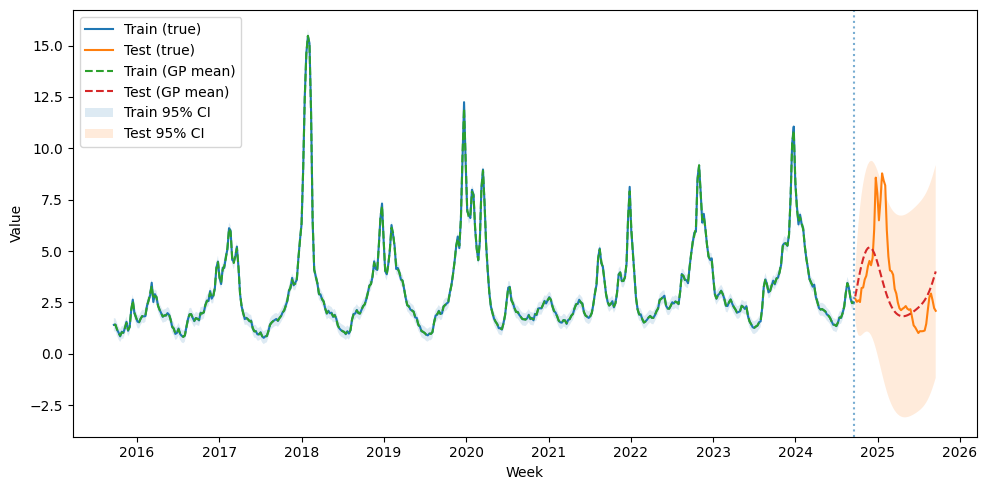

In [ ]:
fig, ax = gp_forecast_plot_from_fit(
    res,
    time_points=df["week_start"],      # length = n_train + n_test
    xlabel="Week",
    ylabel="Value",
	title=None
)

In [ ]:
import numpy as np
import pandas as pd

# --- CONFIG ---
n_train = 468
missing_rates = np.round(np.arange(0.0, 0.81, 0.1), 2)   # 0.0 ... 0.8
period_steps = 52
gp_restarts = 5
base_seed = 12345

region_cols = [c for c in df.columns if c not in ["YEARWEEK", "week_start"]]
# region_cols = region_cols[:1].copy()
# Make sure it's truly a DataFrame (not Series), with explicit index/columns names
results_10_missing = pd.DataFrame(
    index=pd.Index(missing_rates, name="missing_rate"),
    columns=pd.Index(region_cols, name="region"),
    dtype=object
)

for region_idx, region in enumerate(region_cols):
    y = df[region].to_numpy(dtype=float)
    train_full = y[:n_train].copy()
    test_full  = y[n_train:].copy()
    assert np.isfinite(train_full).all(), f"Train has NaNs for region {region}."

    for r_idx, rate in enumerate(missing_rates):
        rng = np.random.default_rng(base_seed + region_idx * 10_000 + r_idx)

        train_masked = train_full.copy()
        k = int(round(rate * len(train_masked)))
        if k > 0:
            drop_idx = rng.choice(len(train_masked), size=k, replace=False)
            train_masked[drop_idx] = np.nan
            # ensure at least 2 observed remain
            obs_count = int(np.isfinite(train_masked).sum())
            if obs_count < 2:
                to_restore = rng.choice(drop_idx, size=(2 - obs_count), replace=False)
                train_masked[to_restore] = train_full[to_restore]

        res = gp_forecast_fit(
            train=train_masked,
            test=test_full,
            period_steps=period_steps,
            use_trend=True,
            n_restarts=gp_restarts,
            random_state=0
        )

        # POSitional assignment avoids the "Incompatible indexer with Series" issue
        results_10_missing.iat[r_idx, region_idx] = res

results_10_missing.to_pickle("results_10_missing.pkl.gz")
# Example access:
# saved = results_df.iat[3, 0]              # 4th missing rate, 1st region
# saved = results_df.loc[0.3, region_cols[0]]  # works too once populated



In [ ]:
df_half = df.copy()
df_half = df_half.iloc[len(df_half) // 2 :].reset_index(drop=True)

n_train = 208
missing_rates = np.round(np.arange(0.0, 0.81, 0.1), 2)   # 0.0 ... 0.8
period_steps = 52
gp_restarts = 5
base_seed = 12345

region_cols = [c for c in df_half.columns if c not in ["YEARWEEK", "week_start"]]
# region_cols = region_cols[:1].copy()
# Make sure it's truly a DataFrame (not Series), with explicit index/columns names
results_5_missing = pd.DataFrame(
    index=pd.Index(missing_rates, name="missing_rate"),
    columns=pd.Index(region_cols, name="region"),
    dtype=object
)

for region_idx, region in enumerate(region_cols):
    y = df_half[region].to_numpy(dtype=float)
    train_full = y[:n_train].copy()
    test_full  = y[n_train:].copy()
    assert np.isfinite(train_full).all(), f"Train has NaNs for region {region}."

    for r_idx, rate in enumerate(missing_rates):
        rng = np.random.default_rng(base_seed + region_idx * 10_000 + r_idx)

        train_masked = train_full.copy()
        k = int(round(rate * len(train_masked)))
        if k > 0:
            drop_idx = rng.choice(len(train_masked), size=k, replace=False)
            train_masked[drop_idx] = np.nan
            # ensure at least 2 observed remain
            obs_count = int(np.isfinite(train_masked).sum())
            if obs_count < 2:
                to_restore = rng.choice(drop_idx, size=(2 - obs_count), replace=False)
                train_masked[to_restore] = train_full[to_restore]

        res = gp_forecast_fit(
            train=train_masked,
            test=test_full,
            period_steps=period_steps,
            use_trend=True,
            n_restarts=gp_restarts,
            random_state=0
        )

        # POSitional assignment avoids the "Incompatible indexer with Series" issue
        results_5_missing.iat[r_idx, region_idx] = res

results_5_missing.to_pickle("results_5_missing.pkl.gz")

In [12]:
def compute_split_idx_after_min_with_weight(test_vals: np.ndarray, w: float) -> int:
    """
    Return j* in test-index space (0..len(test)), where all test points with idx < j*
    are moved to train. Uses:
      - max over finite test values,
      - min strictly BEFORE that max,
      - threshold = w*max + (1-w)*min,
      - j* = first index STRICTLY AFTER min where test >= threshold.
    If not found (or insufficient data), returns 0 (no change).
    """
    t = np.asarray(test_vals, float).ravel()
    finite = np.isfinite(t)

    idx_fin = np.where(finite)[0]

    # Highest point (argmax among finite)
    idx_max = idx_fin[np.argmax(t[idx_fin])]
    max_val = t[idx_max]

    # Min strictly before max (fallback to earliest finite if none)
    before = idx_fin[idx_fin < idx_max]
    if before.size > 0:
        idx_min = before[np.argmin(t[before])]
    else:
        idx_min = idx_fin[0]

    min_val = t[idx_min]

    # Threshold
    thr = w * max_val + (1.0 - w) * min_val

    # First index strictly AFTER min reaching/exceeding threshold
    after_min = idx_fin[idx_fin > idx_min]
    if after_min.size == 0:
        return 0
    reach = after_min[t[after_min] >= thr]
    if reach.size == 0:
        return 0
    return int(reach[0])

In [ ]:
# --- CONFIG ---
n_train = 468
period_steps = 52
gp_restarts = 5

weight_grid = [("0", 0), ("1/4", 1/4), ("1/3", 1/3), ("1/2", 1/2), ("2/3", 2/3), ("3/4", 3/4)]

region_cols = [c for c in df.columns if c not in ["YEARWEEK", "week_start"]]
# region_cols = region_cols[:1].copy()

weight_labels = [lab for lab, _ in weight_grid]
results_10_w = pd.DataFrame(
    index=pd.Index(weight_labels, name="weight"),
    columns=pd.Index(region_cols, name="region"),
    dtype=object
)

for c_idx, region in enumerate(region_cols):
    y = df[region].to_numpy(float)
    train0, test0 = y[:n_train].copy(), y[n_train:].copy()

    for r_idx, (lab, w) in enumerate(weight_grid):
        j_move = compute_split_idx_after_min_with_weight(test0, w)
        split_abs = n_train + j_move

        res = gp_forecast_fit(
            train=y[:split_abs].copy(),
            test=y[split_abs:].copy(),
            period_steps=52,
            use_trend=True,
            n_restarts=gp_restarts,
            random_state=0
        )

        # Positional, integer-based assignment (bulletproof)
        results_10_w.iat[r_idx, c_idx] = res

# Save
results_10_w.to_pickle("results_10_w.pkl.gz")

In [ ]:
# --- CONFIG ---
n_train = 208
period_steps = 52
gp_restarts = 5

weight_grid = [("0", 0), ("1/4", 1/4), ("1/3", 1/3), ("1/2", 1/2), ("2/3", 2/3), ("3/4", 3/4)]

region_cols = [c for c in df.columns if c not in ["YEARWEEK", "week_start"]]
# region_cols = region_cols[:1].copy()

weight_labels = [lab for lab, _ in weight_grid]
results_5_w = pd.DataFrame(
    index=pd.Index(weight_labels, name="weight"),
    columns=pd.Index(region_cols, name="region"),
    dtype=object
)

for c_idx, region in enumerate(region_cols):
    y = df_half[region].to_numpy(float)
    train0, test0 = y[:n_train].copy(), y[n_train:].copy()

    for r_idx, (lab, w) in enumerate(weight_grid):
        j_move = compute_split_idx_after_min_with_weight(test0, w)
        split_abs = n_train + j_move

        res = gp_forecast_fit(
            train=y[:split_abs].copy(),
            test=y[split_abs:].copy(),
            period_steps=52,
            use_trend=True,
            n_restarts=gp_restarts,
            random_state=0
        )

        # Positional, integer-based assignment (bulletproof)
        results_5_w.iat[r_idx, c_idx] = res

# Save
results_5_w.to_pickle("results_5_w.pkl.gz")

In [ ]:
fig, ax = gp_forecast_plot_from_fit(
    results_5_w.iat[4, 0],
    time_points=df_half["week_start"],      # length = n_train + n_test
    xlabel="Week",
    ylabel="Value"
)

In [30]:
import numpy as np
import pandas as pd

def _peak_metrics_steps(y_true, y_pred):
    y_true = np.asarray(y_true, float).ravel()
    y_pred = np.asarray(y_pred, float).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have same shape")

    mask = np.isfinite(y_true)
    if mask.sum() == 0:
        return {
            "mae": np.nan,
            "mse": np.nan,
            "peak_val_mae": np.nan,
            "peak_day_mae_steps": np.nan,
        }

    yt = y_true[mask]
    yp = y_pred[mask]

    mae = float(np.mean(np.abs(yp - yt)))
    mse = float(np.mean((yp - yt) ** 2))

    idx_true_peak_rel = int(np.argmax(yt))
    idx_pred_peak_rel = int(np.argmax(yp))

    true_peak_val = float(yt[idx_true_peak_rel])
    pred_peak_val = float(yp[idx_pred_peak_rel])

    return {
        "mae": mae,
        "mse": mse,
        "peak_val_mae": float(abs(pred_peak_val - true_peak_val)),
        "peak_day_mae_steps": int(abs(idx_pred_peak_rel - idx_true_peak_rel)),
    }


def compute_metrics_matrix(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    For a DataFrame whose cells are dicts returned by `gp_forecast_fit`,
    return a DataFrame of the SAME SHAPE; each cell is a dict of metrics:

        {
          'mae': ...,
          'mse': ...,
          'peak_val_mae': ...,
          'peak_day_mae_steps': ...  # steps (index distance)
        }

    Metrics are computed on the TEST portion only and only where y_true is finite.
    Uses positional indexing (.iat) to avoid pandas Series indexer issues.
    """
    # Ensure we have a real 2D frame
    if not isinstance(results_df, pd.DataFrame):
        raise TypeError("results_df must be a pandas DataFrame")

    out = pd.DataFrame(index=results_df.index.copy(),
                       columns=results_df.columns.copy(),
                       dtype=object)

    n_rows, n_cols = results_df.shape
    for i in range(n_rows):
        for j in range(n_cols):
            res = results_df.iat[i, j]
            if not isinstance(res, dict) or ("test" not in res) or ("y_pred_test" not in res):
                out.iat[i, j] = {
                    "mae": np.nan,
                    "mse": np.nan,
                    "peak_val_mae": np.nan,
                    "peak_day_mae_steps": np.nan,
                }
                continue

            y_true_test = np.asarray(res["test"], dtype=float)
            y_pred_test = np.asarray(res["y_pred_test"], dtype=float)

            metrics = _peak_metrics_steps(y_true_test, y_pred_test)
            out.iat[i, j] = metrics

    return out



In [32]:
metrics_10_w = compute_metrics_matrix(results_10_w)
metrics_5_w = compute_metrics_matrix(results_5_w)
metrics_10_missing = compute_metrics_matrix(results_10_missing)
metrics_5_missing = compute_metrics_matrix(results_5_missing)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def extract_metric_matrix(results_df: pd.DataFrame, metric_key: str) -> pd.DataFrame:
    """
    Convert a DataFrame of metric dicts into a numeric DataFrame for one metric.
    Each cell in results_df is a dict with keys like:
      'mae', 'mse', 'peak_val_mae', 'peak_day_mae_steps'
    """
    out = pd.DataFrame(index=results_df.index.copy(),
                       columns=results_df.columns.copy(),
                       dtype=float)
    n_rows, n_cols = results_df.shape
    for i in range(n_rows):
        for j in range(n_cols):
            cell = results_df.iat[i, j]
            if isinstance(cell, dict) and (metric_key in cell):
                val = cell[metric_key]
                try:
                    out.iat[i, j] = float(val)
                except Exception:
                    out.iat[i, j] = np.nan
            else:
                out.iat[i, j] = np.nan
    return out


def boxplot_rows(numeric_df: pd.DataFrame, title: str, ylabel: str = "", rotation: int = 0):
    """
    Make ONE box plot per ROW.
      • Each box shows the distribution across all columns in that row.
      • Also computes row-wise mean and std (across columns).
    Returns (fig, ax, row_means, row_stds).
    """
    # Row-wise stats across ALL columns
    row_means = numeric_df.mean(axis=1, skipna=True)
    row_stds  = numeric_df.std(axis=1, skipna=True)

    # Data for boxplot: list of arrays per row
    data = [numeric_df.loc[idx].dropna().values for idx in numeric_df.index]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot(data, showmeans=False, patch_artist=False)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Row")
    ax.set_xticks(np.arange(1, len(numeric_df.index) + 1))
    ax.set_xticklabels(list(numeric_df.index), rotation=rotation, ha='right')
    ax.grid(axis='y', linestyle=':', alpha=0.4)
    fig.tight_layout()
    return fig, ax, row_means, row_stds


# ----- Produce 16 figures -----
frames = {
    "10_w": metrics_10_w,
    "5_w": metrics_5_w,
    "10_missing": metrics_10_missing,
    "5_missing": metrics_5_missing,
}
metric_keys = [
    ("mae", "MAE"),
    ("mse", "MSE"),
    ("peak_val_mae", "Peak Value MAE"),
    ("peak_day_mae_steps", "Peak Day MAE (steps)"),
]

# Optionally collect the row stats for later use
row_means_all = {}
row_stds_all  = {}

for frame_name, res_df in frames.items():
    for key, key_label in metric_keys:
        num_df = extract_metric_matrix(res_df, key)
        fig, ax, row_means, row_stds = boxplot_rows(
            num_df,
            title=f"{frame_name} — {key_label} (box per row across columns)",
            ylabel=key_label,
            rotation=0  # set to 60 if your row labels are long
        )
        # Optional: save
        # fig.savefig(f"{frame_name}_{key}_rows_boxplot.png", dpi=150, bbox_inches="tight")

        row_means_all[(frame_name, key)] = row_means
        row_stds_all[(frame_name, key)]  = row_stds


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def paired_row_boxplot_single(
    results_A,
    results_B,
    metric_key: str,
    extract_fn,
    *,
    row_order=None,
    figsize=(14, 5),
    box_width=0.35,
    rotation=0,
    # Labels and title
    x_label="Row",
    y_label=None,
    title=None,
    # Legend controls
    show_legend=True,
    legend_labels=None,        # e.g., ["10_w", "5_w"]
    legend_loc="best",
    # Colors
    colorA=None,
    colorB=None,
    # Style
    alpha=0.35,
):
    """
    Single figure for ONE metric comparing two result DataFrames.
    For each ROW, plot two colored boxes side-by-side: left from A, right from B.

    Args:
        results_A, results_B : pd.DataFrame (or compatible)
            DataFrames holding metric matrices retrievable via `extract_fn(df, metric_key)`.
            The returned matrices must share row indices (states/regions/etc.).
        metric_key : str
            Key to pass into `extract_fn` to extract the metric matrix.
        extract_fn : callable
            Function of the form `extract_fn(df, metric_key) -> pd.DataFrame`
            returning a 2D frame with rows = entities, cols = replicate runs/conditions.
        row_order : list or None
            If provided, enforce this order of rows on the x-axis.
        x_label, y_label, title : str
            Axis labels and figure title. If y_label is None, defaults to `metric_key`.
        show_legend : bool
            Whether to display a legend.
        legend_labels : list[str] or None
            Labels for A and B in the legend. Defaults to ["A", "B"] if not provided.
        legend_loc : str
            Matplotlib legend location.
        colorA, colorB : str or None
            Matplotlib colors for A and B. Defaults to first two colors in rcParams.
        alpha : float
            Face alpha for the box patches.

    Returns:
        (fig, ax) : Matplotlib figure and axes.
    """
    # ---- Extract metric matrices ----
    A = extract_fn(results_A, metric_key)
    B = extract_fn(results_B, metric_key)

    # ---- Align rows ----
    if row_order is None:
        rows = list(A.index)
    else:
        rows = list(row_order)
        A = A.reindex(index=rows)
    if list(B.index) != rows:
        B = B.reindex(index=rows)

    # ---- Positions for paired boxes ----
    n_rows = len(rows)
    centers = np.arange(1, n_rows + 1, dtype=float)
    pos_A = centers - box_width / 2.0
    pos_B = centers + box_width / 2.0

    # ---- Per-row distributions (across columns) ----
    data_A = [A.loc[r].dropna().values for r in rows]
    data_B = [B.loc[r].dropna().values for r in rows]

    # ---- Figure & axes ----
    fig, ax = plt.subplots(figsize=figsize)

    # ---- Colors ----
    cycle_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0', 'C1'])
    colorA = colorA or cycle_colors[0]
    colorB = colorB or (cycle_colors[1] if len(cycle_colors) > 1 else 'C1')

    # ---- Draw boxplots ----
    bpA = ax.boxplot(
        data_A, positions=pos_A, widths=box_width,
        showmeans=False, patch_artist=True, manage_ticks=False
    )
    bpB = ax.boxplot(
        data_B, positions=pos_B, widths=box_width,
        showmeans=False, patch_artist=True, manage_ticks=False
    )

    # ---- Styling helper ----
    def _color_boxplot(bp, color):
        for box in bp['boxes']:
            box.set(facecolor=color, edgecolor=color, alpha=alpha, linewidth=1.5)
        for med in bp['medians']:
            med.set(color=color, linewidth=2.0)
        for whisk in bp['whiskers']:
            whisk.set(color=color, linewidth=1.5)
        for cap in bp['caps']:
            cap.set(color=color, linewidth=1.5)
        if 'fliers' in bp:
            for fl in bp['fliers']:
                fl.set(marker='o', markerfacecolor=color, markeredgecolor=color, alpha=0.6, markersize=4)

    _color_boxplot(bpA, colorA)
    _color_boxplot(bpB, colorB)

    # ---- Axes labels, ticks, title ----
    ax.set_xticks(centers)
    ax.set_xticklabels(rows, rotation=rotation, ha='right')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label if y_label is not None else metric_key)
    if title:
        ax.set_title(title)
    ax.grid(axis='y', linestyle=':', alpha=0.4)

    # ---- Legend ----
    if show_legend:
        legend_elems = [
            Line2D([0], [0], color=colorA, lw=4, label=(legend_labels[0] if legend_labels else "A")),
            Line2D([0], [0], color=colorB, lw=4, label=(legend_labels[1] if legend_labels else "B")),
        ]
        ax.legend(handles=legend_elems, loc=legend_loc)

    fig.tight_layout()
    return fig, ax


In [ ]:
metric_specs = [
    ("mae", "MAE"),
    ("mse", "MSE"),
    ("peak_val_mae", "Peak Value MAE"),
    ("peak_day_mae_steps", "Peak Day MAE (steps)"),
]

pairs = [
    ("9 Years Training (Full)",      "4 Years Training (Full)",      metrics_10_w,      metrics_5_w),
    ("9 Years Training","4 Years Training",metrics_10_missing,metrics_5_missing),
]

figs = {}
for nameA, nameB, dfA, dfB in pairs:
    for key, label in metric_specs:
        fig, ax = paired_row_boxplot_single(
            results_A=dfA,
            results_B=dfB,
            metric_key=key,
            extract_fn=extract_metric_matrix,
            x_label="Observation Level (Trough → Peak Fraction)",
            y_label=label,
            legend_labels=[nameA, nameB],
            legend_loc="best",
            rotation=0,
            figsize=(10, 5),
            box_width=0.35,
        )
        figs[(f"{nameA}_vs_{nameB}", key)] = (fig, ax)
